### Erforderliche Pakete importieren

In [5]:
import os
from typing import List, Tuple, Set, Optional
import random
import matplotlib.pyplot as plt
import numpy as np
!pip install sklearn-crfsuite
import pycrfsuite # https://pypi.org/project/python-crfsuite/
!python -m spacy download en_core_web_md
import spacy
NLP = spacy.load("en_core_web_md")
en_vocab = NLP.vocab
from sklearn_crfsuite import metrics
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-12 08:01:17.647722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 08:01:18.773995: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-12 08:01:18.774125: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could no

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Das Originalformat der CoNLL2003 NER-Daten

Jedes Wort wird mit seinem Text, Part-of-Speech Tag, Noun-Chunk Tag und Named-Entity Tag dargestellt

![image-4.png](attachment:image-4.png)

### Der manipulierten Daten offnen

WICHTIG: Bevor Sie die nächste Zelle ausführen, vergewissern Sie sich, dass Sie den Ordner 'CoNLL_2003' und dessen Inhalt aus den Kursübungsdateien heruntergeladen haben. Ändern Sie dann den Dateipfad im unten stehenden Code, um den Speicherort auf Ihrem Computer wiederzugeben, an dem Sie diesen Ordner gespeichert haben. 

In [37]:
#Copy txt files to Google Colab directory
data_directory = "."
with open(os.path.join(data_directory, "train_sent_words.txt")) as f:
    train_raw = f.readlines()
with open(os.path.join(data_directory, "test_sent_words.txt")) as f:
    test_raw = f.readlines()
with open(os.path.join(data_directory, "valid_sent_words.txt")) as f:
    valid_raw = f.readlines()

In [ ]:
train_raw[:5]

### Ein Feature Extractor Definieren

In [38]:
def get_word_features(doc: spacy.tokens.doc.Doc,
                      token_idx: int) -> List[str]:
    """
    Given a document object and a token_idx identifying a specific token, extract and select features to represent that token.

    Args:
        doc: a spaCy Document object representing a single, processed sentence
        token_idx: the index of the token around which features should be extracted
    Returns:
        features: a list of features represented as strings
    """
    # FEATURE EXTRACTION
    token = doc[token_idx]
    postag = token.pos_
    first_three_chars = token.text if len(token.text) <= 3 else token.text[:3]
    last_three_chars = token.text if len(token.text) <= 3 else token.text[-3:]
    # Die beiden oben genannten features macht mas Modell robust
    # gegenüber Tippfehlern. z. B. wenn "running" als "runing"
    # geschrieben wurde, kennt das Modell trotzdem "run" und "ing"
    known_word = str(not token.is_oov)

    # FEATURE SELECTION
    features = [
        f'wordlen={str(len(token))}',
        f'shape={token.shape_}',
        # Shape wandelt Klein- und Großbuchstaben in 'x' und 'X', &
        # Ziffern in 'd' um, und schneidet eine beliebige Folge von 
        # identischen Zeichen auf maximal 4 ab.
        # zB 'spaCy' -> 'xxxXx' & 'Tokens' -> Xxxxx
        f'prefix3={first_three_chars}',
        f'suffix3={last_three_chars}',
        f'pos={postag}',
        f'word={token.text}',
        f'en-wordlist=%s{known_word}',
        'bias',
    ]
    return features

In [39]:
# Ein verbesserter Feature extractor
def get_token_ent(token: spacy.tokens.token.Token) -> str:
    """
    Given a spaCy token object, extract the token's entity label as a string, using the appropriate I.O.B. schema
    """
    ent = f"{token.ent_iob_}-{token.ent_type_}" if token.ent_iob_ != "O" else "O"
    return ent

def get_word_features(doc: spacy.tokens.doc.Doc, token_idx: int) -> List[str]:
    """
    Given a document object and a token_idx identifying a specific token, extract and select features to represent that token.

    Args:
        doc: a spaCy Document object representing a single, processed sentence
        token_idx: the index of the token around which features should be extracted
    Returns:
        features: a list of features represented as strings
    """
    # FEATURE EXTRACTION
    # Aktuelle Wort Features
    token = doc[token_idx]
    postag = token.pos_
    first_three_chars = token.text if len(token.text) <= 3 else token.text[:3]
    last_three_chars = token.text if len(token.text) <= 3 else token.text[-3:]
    # Die beiden oben genannten features macht mas Modell robust
    # gegenüber Tippfehlern. z. B. wenn "running" als "runing"
    # geschrieben wurde, kennt das Modell trotzdem "run" und "ing"
    known_word = str(not token.is_oov)

    # Vorherige Wort Features
    if token_idx > 0:
        prev_token = doc[token_idx - 1]
        prevword = token.nbor(-1).lower_
        prevpos = prev_token.pos_
        prevtag = get_token_ent(prev_token)
        prevshape = prev_token.shape_
    else:
        prevword = prevpos = prevtag = prevshape = ""

    # Nächstes Wort Features
    if token_idx < len(doc) - 1:
        nextword = token.nbor(1).lower_
        nextpos = doc[token_idx + 1].pos_
    else:
        nextword = nextpos = ""

    # FEATURE SELECTION
    features = [
        f'wordlen={str(len(token))}',
        f'shape={token.shape_}',
        f'prefix3={first_three_chars}',
        f'suffix3={last_three_chars}',
        f'pos={postag}',
        f'word={token.text}',
        f'en-wordlist=%s{known_word}',
        f'prevword={prevword}',
        f'prevpos={prevpos}',
        f'prevtag={prevtag}',
        f'prevshape{prevshape}',
        f'nextword={nextword}',
        f'nextpos={nextpos}',
        f'word+nextpos={token.lower_}+{nextpos}',
        f'pos+prevtag={postag}+{prevtag}',
        f'shape+prevtag={token.shape_}+{prevtag}',
        'bias',
    ]
    return features

### Daten verarbeiten (Datensatzsätzen in spaCy Document-Objekte Konvertieren; Features extrahieren und auswählen)

In [40]:
def sents_to_docs(raw_data: List[str], nlp) -> List[spacy.tokens.doc.Doc]:
    """
    Convert a list of sentences into a list of spaCy Doc objects

    Args:
        raw_data: a list of sentence strings
        nlp: A spacy language model object, eg. spacy.lang.en.English
    """
    return [nlp(sent) for sent in raw_data]


def get_sentence_features(doc: spacy.tokens.doc.Doc) -> List[List[str]]:
    """
    Given a processed sentence represented as a Document object, extract and select features for each individual token

    Return: a list of words in a sentence, where each word is represented as a list of features
    """
    return [get_word_features(doc, token_idx) for token_idx, token in enumerate(doc)]

In [41]:
train_sent_docs = sents_to_docs(train_raw, NLP)
test_sent_docs = sents_to_docs(test_raw, NLP)
valid_sent_docs = sents_to_docs(valid_raw, NLP)

X_train = [get_sentence_features(s) for s in train_sent_docs]
X_test = [get_sentence_features(s) for s in test_sent_docs]
X_valid = [get_sentence_features(s) for s in valid_sent_docs]

In [42]:
X_train[0]

[['wordlen=2',
  'shape=XX',
  'prefix3=EU',
  'suffix3=EU',
  'pos=PROPN',
  'word=EU',
  'en-wordlist=%sTrue',
  'prevword=',
  'prevpos=',
  'prevtag=',
  'prevshape',
  'nextword=rejects',
  'nextpos=VERB',
  'word+nextpos=eu+VERB',
  'pos+prevtag=PROPN+',
  'shape+prevtag=XX+',
  'bias'],
 ['wordlen=7',
  'shape=xxxx',
  'prefix3=rej',
  'suffix3=cts',
  'pos=VERB',
  'word=rejects',
  'en-wordlist=%sTrue',
  'prevword=eu',
  'prevpos=PROPN',
  'prevtag=B-ORG',
  'prevshapeXX',
  'nextword=german',
  'nextpos=ADJ',
  'word+nextpos=rejects+ADJ',
  'pos+prevtag=VERB+B-ORG',
  'shape+prevtag=xxxx+B-ORG',
  'bias'],
 ['wordlen=6',
  'shape=Xxxxx',
  'prefix3=Ger',
  'suffix3=man',
  'pos=ADJ',
  'word=German',
  'en-wordlist=%sTrue',
  'prevword=rejects',
  'prevpos=VERB',
  'prevtag=O',
  'prevshapexxxx',
  'nextword=call',
  'nextpos=NOUN',
  'word+nextpos=german+NOUN',
  'pos+prevtag=ADJ+O',
  'shape+prevtag=Xxxxx+O',
  'bias'],
 ['wordlen=4',
  'shape=xxxx',
  'prefix3=cal',
  'su

### Labels vorbereiten

In [43]:
def get_token_ent(token: spacy.tokens.token.Token) -> str:
    """
    Given a spaCy token object, extract the token's entity label as a string, using the appropriate I.O.B. schema
    """
    ent = f"{token.ent_iob_}-{token.ent_type_}" if token.ent_iob_ != "O" else "O"
    return ent

def get_sent_entities(doc: spacy.tokens.doc.Doc) -> List[str]:
    """
    Given a document object representing a processed sentence, return the entity labels of that sentence as strings
    """
    return [get_token_ent(token) for token in doc]

In [44]:
y_train = [get_sent_entities(s) for s in train_sent_docs]
y_test = [get_sent_entities(s) for s in test_sent_docs]
y_valid = [get_sent_entities(s) for s in valid_sent_docs]

### pycrfsuite.Trainer Erzeugen, Trainingsdaten hinein laden.

- Crfsuite source code:  https://github.com/scrapinghub/python-crfsuite/blob/master/pycrfsuite/_pycrfsuite.pyx
- Crfsuite example: https://github.com/scrapinghub/python-crfsuite/blob/master/examples/CoNLL%202002.ipynb
- Limited-memory_BFGS: https://en.wikipedia.org/wiki/Limited-memory_BFGS 
- Elastic Net: https://machinelearningmastery.com/elastic-net-regression-in-python/


In [45]:
trainer = pycrfsuite.Trainer(verbose=False)
for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

# Das crfsuite-Beispiel für Training CRFs für NER verwendet gradient descent
# mit dem L-BFGS Trainingsalgorithmus & Elastic Net (L1 + L2) Regularisierung
# Es verwendet 1.0 and 1e-3 für die L1 & l2 Penalty Koeffizienten,
# 50 für maximale Trainingsiterationen,
# und erlaubt es, Übergänge einzubeziehen, die nicht gesehen werden, aber möglich sind

# Wir bleiben bei diesen Voreinstellungen
trainer.set_params({
    'c1': 1.0,
    'c2': 1e-3,
    'max_iterations': 50,
    'feature.possible_transitions': True
})

### Das Modell Trainieren, und in dem mit 'model' angegebenen Pfad speichern

In [51]:
trainer.train(model='./conll2003-esp.crfsuite')

### Vorhersagen für den Validierungssatz (Validation Set) machen

In [52]:
# Make predictions
tagger = pycrfsuite.Tagger() # Source code: https://github.com/scrapinghub/python-crfsuite/blob/master/pycrfsuite/_pycrfsuite.pyx
tagger.open('./conll2003-esp.crfsuite')

y_valid_pred = [tagger.tag(xseq) for xseq in X_valid]

In [53]:
# Einige Vorhersagen anzeigen
for pred in random.sample(y_valid_pred, 10):
    print(" \t ".join(pred))

B-GPE 	 I-GPE 	 I-GPE 	 O 	 B-GPE 	 O 	 B-GPE 	 B-CARDINAL 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 B-DATE 	 O 	 O 	 O 	 O 	 B-GPE 	 O 	 O 	 O 	 O 	 B-GPE 	 B-DATE 	 I-DATE 	 O 	 O 	 O 	 O 	 O
B-PERSON 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 B-NORP 	 O 	 O 	 O 	 O 	 O 	 O 	 B-GPE 	 O 	 B-GPE 	 O 	 B-DATE 	 O 	 O 	 O 	 O 	 O 	 B-QUANTITY 	 I-QUANTITY 	 O 	 B-QUANTITY 	 I-QUANTITY 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 B-QUANTITY 	 I-QUANTITY 	 O 	 B-QUANTITY 	 I-QUANTITY 	 O 	 O 	 O 	 O 	 O
O 	 O 	 B-EVENT 	 I-EVENT 	 I-EVENT 	 I-EVENT 	 I-EVENT 	 O 	 B-ORG 	 I-ORG 	 I-ORG 	 I-ORG 	 O 	 B-DATE 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O
O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 O 	 B-PERSON 	 O 	 O 	 O
B-CARDINAL 	 O 	 B-PERSON 	 I-PERSON 	 O 	 B-GPE 	 O 	 B-CARDINAL 	 O
B-PERSON 	 O 	 B-DATE 	 I-DATE 	 I-DATE 	 I-DATE 	 O 	 O 	 O 	 O 	 B-CARDINAL 	 O 	 O 	 O 	 O 	 B-GPE 	 O 	 O 	 O 	 O 	 O 	 O
B

### Evaluieren

In [54]:
def get_observed_entities(docs: List[spacy.tokens.doc.Doc]) -> Set[str]:
    """
    Given a list of sentences represented as Document objects, return the set of all entity labels observed in those sentences
    """
    classes = set()
    for doc in docs:
        for token in doc:
            classes.add(get_token_ent(token))
    return classes

In [55]:
# Get all possible entity classes (required for evaluation)
seen_labels_valid = get_observed_entities(valid_sent_docs)
seen_labels_valid = sorted(seen_labels_valid, key = lambda x: x[2:])
seen_labels_valid.remove('O')

In [56]:
# Print classification report
print("Validation set results")
print(metrics.flat_classification_report(y_true=y_valid,
                                         y_pred=y_valid_pred,
                                         labels=seen_labels_valid,
                                         zero_division=0))

Validation set results


TypeError: ignored

In [57]:
def get_confusion_matrix(entities_true: List[List[str]],
                         entities_pred: List[List[str]],
                         entity_labels: List[str],
                         normalize: Optional = None):
    """
    normalize{‘true’, ‘pred’, ‘all’}, default=None
    Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. If None, confusion matrix will not be normalized.
    """
    
    true_combined = itertools.chain.from_iterable(entities_true)
    pred_combined = itertools.chain.from_iterable(entities_pred)
    
    return confusion_matrix(list(true_combined), list(pred_combined), labels=entity_labels, normalize=normalize)

In [58]:
valid_confusion_matrix = get_confusion_matrix(entities_true=y_valid,
                                              entities_pred=y_valid_pred,
                                              entity_labels=seen_labels_valid)

valid_confusion_matrix_df = pd.DataFrame(valid_confusion_matrix, columns=seen_labels_valid, index=seen_labels_valid)
print("CONFUSION MATRIX FOR VALIDATION RESULTS. TRUE CLASSESS (Y-AXIS) VS PREDICTED CLASSES (X-AXIS)")
valid_confusion_matrix_df

CONFUSION MATRIX FOR VALIDATION RESULTS. TRUE CLASSESS (Y-AXIS) VS PREDICTED CLASSES (X-AXIS)


,B-CARDINAL,I-CARDINAL,B-DATE,I-DATE,B-EVENT,I-EVENT,I-FAC,B-FAC,I-GPE,B-GPE,B-LANGUAGE,B-LAW,I-LAW,I-LOC,B-LOC,I-MONEY,B-MONEY,I-NORP,B-NORP,B-ORDINAL,I-ORG,B-ORG,B-PERCENT,I-PERCENT,B-PERSON,I-PERSON,I-PRODUCT,B-PRODUCT,B-QUANTITY,I-QUANTITY,I-TIME,B-TIME,I-WORK_OF_ART,B-WORK_OF_ART
B-CARDINAL,1627,4,1,6,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,9,1,0,2,1,7,0,0,0,0,0,0,0,0
I-CARDINAL,5,291,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B-DATE,16,0,1355,7,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,1,0,0,0,0,0,0,0,0
I-DATE,0,0,1,1944,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
B-EVENT,0,0,0,0,79,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
I-EVENT,0,0,0,0,0,130,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
I-FAC,0,0,0,0,0,0,57,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B-FAC,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
I-GPE,2,0,0,0,0,0,0,0,249,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B-GPE,2,0,0,3,0,0,0,0,3,1660,0,0,0,0,1,0,0,0,3,0,5,15,0,0,33,3,0,0,0,0,0,0,1,0


In [59]:
# Was heißt dann, zB, 'CARDINAL'?
spacy.explain("CARDINAL")

'Numerals that do not fall under another type'

In [60]:
valid_confusion_matrix_normed = get_confusion_matrix(entities_true=y_valid,
                                              entities_pred=y_valid_pred,
                                              entity_labels=seen_labels_valid,
                                              normalize='true')

In [61]:
def plot_confusion_matrix(matrix: np.ndarray,
                          entity_labels: List[str],
                          title: str,
                          colour_map: Optional[str] = None) -> None:

    fig = plt.figure(figsize=(14, 8))
    sns.heatmap(matrix, cmap=colour_map, linewidths=0.005, linecolor='lightsteelblue', vmin=matrix.min(), vmax=matrix.max())
    tick_positions = np.array(range(len(entity_labels)))+0.5
    plt.xticks(tick_positions, entity_labels, fontsize=14, rotation=90)
    plt.yticks(tick_positions, entity_labels, fontsize=14, rotation=0)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close(fig)

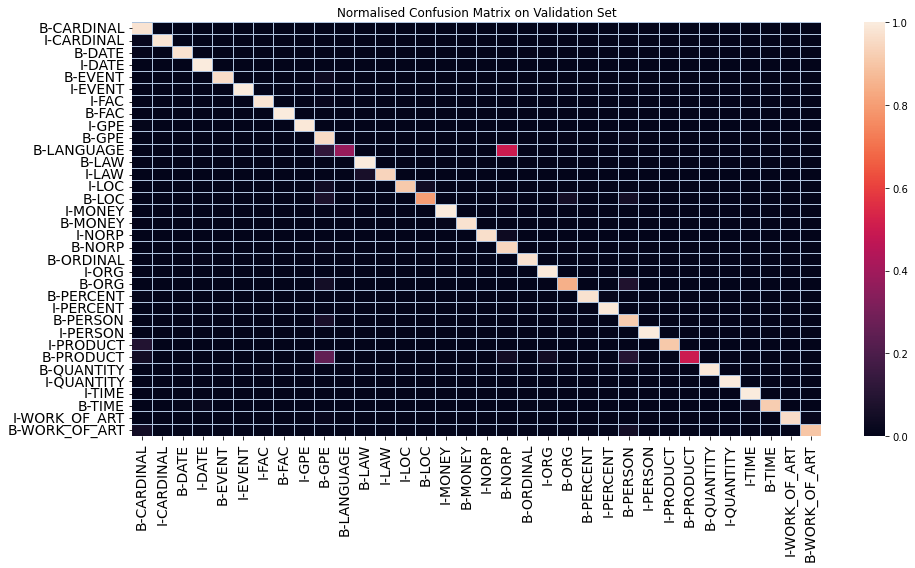

In [62]:
plot_confusion_matrix(matrix=valid_confusion_matrix_normed,
                      entity_labels=seen_labels_valid,
                      title="Normalised Confusion Matrix on Validation Set")

### Ideen zum Verbesserung des Modells

spaCy-Token-Objekte enthalten viele weitere Attribute, die nützlich sein können.

Ein paar, die mir aufgefallen sind, sind: ancestors, children, lefts, rights, n_lefts, n_rights, left_edge, right_edge, i, is_punct, is_left_punct, is_right_punct, is_currency, like_num, is_stop, tag (anstatt pos?), dep_, prob

Unter dem Link finden Sie eine Erklärung und Anwendungsbeispiele: https://spacy.io/api/token

### Hilfsfunktionen zum Schreiben und Lesen von Vorhersagen in und aus einer Datei

In [63]:
def write_results(url: str, docs: List[spacy.tokens.doc.Doc],
                  true_entities: List[List[str]],
                  predicted_entities: List[List[str]]) -> None:
    """
    Given a list of sentences represented as Document objects, and a list of true and predicted labels, write to file.
    """
    with open(url, "w+") as f:
        for doc, true, predicted in zip(docs, true_entities, predicted_entities):
            f.write('\t'.join([token.text for token in doc]) + '\n')
            f.write('\t'.join(true) + '\n')
            f.write('\t'.join(predicted) + '\n')
            f.write('\n\n')

In [64]:
# Write validation set results
write_results("validation_set_predictions.txt",
              valid_sent_docs,
              y_valid,
              y_valid_pred)

In [65]:
def read_results(url: str, true_tags_to_filter: Optional[List[str]] = None) -> None:
    with open(url) as f:
        results = f.readlines()
    words_lines = np.array(range(0, len(results), 5))
    true_lines = words_lines + 1
    predicted_lines = words_lines + 2
    newlines = words_lines + 3
    
    true_tags_to_filter = true_tags_to_filter if true_tags_to_filter else ['']

    for w, t, p, n in zip(words_lines, true_lines, predicted_lines, newlines):
        if any(tag in results[t] for tag in true_tags_to_filter):
            print(results[w])
            print(results[t])
            print(results[p])
            print(results[n])

In [66]:
# Read validation set results
read_results("validation_set_predictions.txt")

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.


O	O	O	O	O	B-GPE	O	B-NORP	O	B-NORP	O	O	O

O	O	O	O	O	B-GPE	O	B-NORP	O	B-NORP	O	O	O



"	We	are	in	close	touch	with	all	our	allies	,	"	said	the	Foreign	Office	spokesman	.	



O	O	O	O	O	O	O	O	O	O	O	O	O	O	B-ORG	I-ORG	O	O	O

O	O	O	O	O	O	O	O	O	O	O	O	O	O	B-ORG	I-ORG	O	O	O



He	declined	to	give	any	further	information	.	



O	O	O	O	O	O	O	O	O





-DOCSTART-	



O	O





Seven	Iraqis	charged	with	hijack	.	

B-CARDINAL	B-NORP	O	O	O	O	O

B-CARDINAL	B-NORP	O	O	O	O	O







B-GPE	B-DATE	I-DATE	I-DATE	I-DATE	I-DATE	O

B-GPE	B-DATE	I-DATE	I-DATE	I-DATE	I-DATE	O



Seven	Iraqi	men	appeared	in	court	on	Saturday	charged	with	air	piracy	following	the	hijacking	to	Britain	of	a	Sudanese	airliner	with	199	people	aboard	.	



B-CARDINAL	B-NORP	O	O	O	O	O	B-DATE	O	O	O	O	O	O	O	O	B-GPE	O	O	B-NORP	O	O	B-CARDINAL	O	O	O	O

B-CARDINAL	B-NORP	O	O	O	O	O	B-DATE	O	O	O	O	O	O	O	O	B-GPE	O	O	B-NORP	O	O	B-CARDINAL	O	O	O	O



The	seven	,	including	a	carpente

### Nach der Verbesserung des Modells die Ergebnisse des Testsatzes auswerten

In [67]:
# Make predictions
tagger = pycrfsuite.Tagger() # Source code: https://github.com/scrapinghub/python-crfsuite/blob/master/pycrfsuite/_pycrfsuite.pyx
tagger.open('conll2003-esp.crfsuite')

y_test_pred = [tagger.tag(xseq) for xseq in X_test]

In [68]:
# Get all possible entity classes (required for evaluation)
seen_labels_test = get_observed_entities(test_sent_docs)
seen_labels_test = sorted(seen_labels_test, key = lambda x: x[2:])
seen_labels_test.remove('O')

print("Test set results")
print(metrics.flat_classification_report(y_true=y_test, y_pred=y_test_pred, labels=seen_labels_test, zero_division=0))

Test set results


TypeError: ignored

In [69]:
test_confusion_matrix = get_confusion_matrix(entities_true=y_test,
                                             entities_pred=y_test_pred,
                                             entity_labels=seen_labels_test)

test_confusion_matrix_df = pd.DataFrame(test_confusion_matrix, columns=seen_labels_test, index=seen_labels_test)
print("CONFUSION MATRIX FOR TEST RESULTS. TRUE CLASSESS (Y-AXIS) VS PREDICTED CLASSES (X-AXIS)")
test_confusion_matrix_df

CONFUSION MATRIX FOR TEST RESULTS. TRUE CLASSESS (Y-AXIS) VS PREDICTED CLASSES (X-AXIS)


,B-CARDINAL,I-CARDINAL,B-DATE,I-DATE,B-EVENT,I-EVENT,I-FAC,B-FAC,I-GPE,B-GPE,B-LANGUAGE,B-LAW,I-LAW,I-LOC,B-LOC,I-MONEY,B-MONEY,I-NORP,B-NORP,B-ORDINAL,I-ORG,B-ORG,B-PERCENT,I-PERCENT,B-PERSON,I-PERSON,I-PRODUCT,B-PRODUCT,B-QUANTITY,I-QUANTITY,I-TIME,B-TIME,I-WORK_OF_ART,B-WORK_OF_ART
B-CARDINAL,1657,26,2,7,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,5,0,0,0,0,4,0,1,0,0,1,0,0,0
I-CARDINAL,21,372,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
B-DATE,16,0,1305,5,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0
I-DATE,2,0,1,1916,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0
B-EVENT,0,0,0,0,69,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
I-EVENT,0,0,0,0,0,109,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
I-FAC,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B-FAC,0,0,0,0,0,0,0,29,0,2,0,0,0,0,0,0,0,0,1,0,0,5,0,0,1,0,0,0,0,0,0,0,0,0
I-GPE,0,0,0,0,0,0,0,0,227,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0
B-GPE,2,0,0,2,0,0,0,0,1,1566,0,0,0,0,1,0,0,0,1,0,13,30,0,0,51,5,0,0,0,0,0,0,0,0


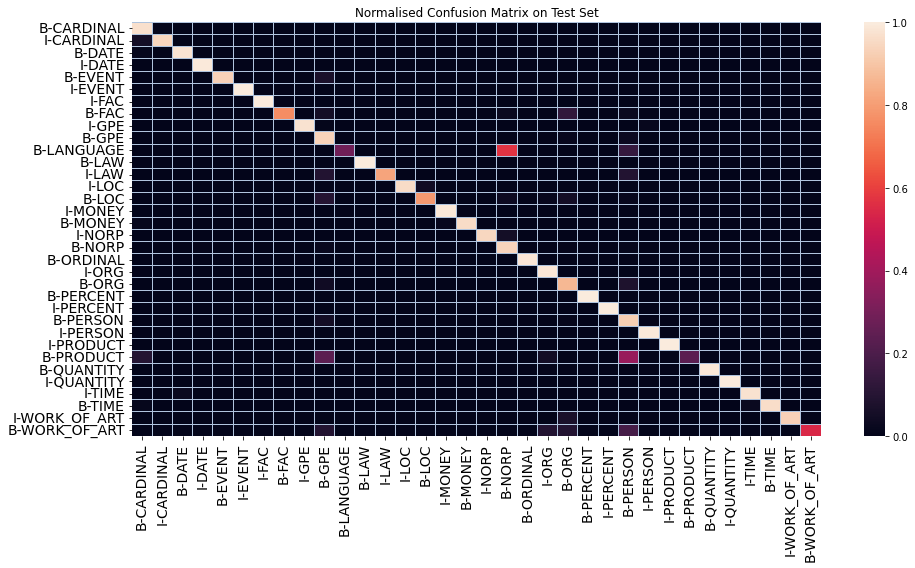

In [70]:
test_confusion_matrix_normed = get_confusion_matrix(entities_true=y_test,
                                             entities_pred=y_test_pred,
                                             entity_labels=seen_labels_test,
                                             normalize='true')

plot_confusion_matrix(matrix=test_confusion_matrix_normed,
                      entity_labels=seen_labels_test,
                      title="Normalised Confusion Matrix on Test Set")

In [71]:
# Write test set results
write_results("test_set_predictions.txt", test_sent_docs, y_test, y_test_pred)